In [1]:
execfile('test_python.py')

###########
# AlGDock #
###########
Molecular docking with adaptively scaled alchemical interaction grids

in /Users/dminh/Applications/miniconda2/envs/algdock/lib/python2.7/site-packages/AlGDock/BindingPMF.py
last modified Sat Dec 17 14:16:29 2016
    
using 4/4 available cores
using random number seed of -1

*** Directories ***
  start: /Users/dminh/Installers/AlGDock-0.0.1/Example
  cool: /Users/dminh/Installers/AlGDock-0.0.1/Example/cool
  dock: /Users/dminh/Installers/AlGDock-0.0.1/Example/dock

>>> Decompressing tarballs
looking for:
  complex.trans.inpcrd
  complex.pdb
  ligand.mol2
  receptor.trans.inpcrd
  ligand.trans.inpcrd
  ligand.prmtop
  ligand.db
  receptor.pdb
  complex.prmtop
  ligand.rb
  receptor.prmtop
  and frcmod files
reading prmtopcrd/receptor.tar.gz
  extracted receptor.pdb
  extracted receptor.prmtop
  extracted receptor.trans.inpcrd
reading /Users/dminh/Installers/AlGDock-0.0.1/Example/prmtopcrd/ligand.tar.gz
  extracted ligand.db
  extracted /Users/dminh/In

In [2]:
print self._dock_cycle

4


In [3]:
from AlGDock.BindingPMF import *
process = 'dock'

# The following is unchanged from _replica_exchange(self, process)
if process=='cool':
  terms = ['MM']
elif self.params['dock']['pose'] > -1:
  # Pose BPMF
  terms = ['MM','misc',\
    'k_angular_ext','k_spatial_ext','k_angular_int'] + self._scalables
else:
  # BPMF
  terms = ['MM','site','misc'] + self._scalables

cycle = getattr(self,'_%s_cycle'%process)
confs = self.confs[process]['replicas']
lambdas = getattr(self,process+'_protocol')

# A list of pairs of replica indicies
K = len(lambdas)
pairs_to_swap = []
for interval in range(1,min(5,K)):
  lower_inds = []
  for lowest_index in range(interval):
    lower_inds += range(lowest_index,K-interval,interval)
  upper_inds = np.array(lower_inds) + interval
  pairs_to_swap += zip(lower_inds,upper_inds)

from repX import attempt_swaps

# Setting the force field will load grids
# before multiple processes are spawned
for k in range(K):
  self._set_universe_evaluator(lambdas[k])

# If it has not been set up, set up Smart Darting
if self.params[process]['darts_per_sweep']>0:
  if self.sampler[process+'_SmartDarting'].confs==[]:
    self.tee(self.sampler[process+'_SmartDarting'].set_confs(\
      self.confs[process]['SmartDarting']))
    self.confs[process]['SmartDarting'] = \
      self.sampler[process+'_SmartDarting'].confs

storage = {}
for var in ['confs','state_inds','energies']:
  storage[var] = []

cycle_start_time = time.time()

if self._cores>1:
  # Multiprocessing setup
  m = multiprocessing.Manager()
  task_queue = m.Queue()
  done_queue = m.Queue()

# MC move statistics
acc = {}
att = {}
for move_type in ['ExternalMC','SmartDarting','Sampler']:
  acc[move_type] = np.zeros(K, dtype=int)
  att[move_type] = np.zeros(K, dtype=int)
  self.timing[move_type] = 0.
self.timing['repX'] = 0.

# Do replica exchange
state_inds = range(K)
inv_state_inds = range(K)
nsweeps = self.params[process]['sweeps_per_cycle']
for sweep in range(nsweeps):
  E = {}
  for term in terms:
    E[term] = np.zeros(K, dtype=float)
  # Sample within each state
  if self._cores>1:
    for k in range(K):
      task_queue.put((confs[k], process, lambdas[state_inds[k]], False, k))
    for p in range(self._cores):
      task_queue.put('STOP')
    processes = [multiprocessing.Process(target=self._sim_one_state_worker, \
        args=(task_queue, done_queue)) for p in range(self._cores)]
    for p in processes:
      p.start()
    for p in processes:
      p.join()
    unordered_results = [done_queue.get() for k in range(K)]
    results = sorted(unordered_results, key=lambda d: d['reference'])
    for p in processes:
      p.terminate()
  else:
    # Single process code
    results = [self._sim_one_state(confs[k], process, \
        lambdas[state_inds[k]], False, k) for k in range(K)]

  # Store energies
  for k in range(K):
    confs[k] = results[k]['confs']
    if process=='cool':
        E['MM'][k] = results[k]['Etot']
  if process=='dock':
    E = self._energyTerms(confs, E) # Get energies for scalables
    # Get rmsd values
    if self.params['dock']['rmsd'] is not False:
      E['rmsd'] = np.array([np.sqrt(((confs[k][self.molecule.heavy_atoms,:] - \
        self.confs['rmsd'])**2).sum()/self.molecule.nhatoms) for k in range(K)])

  # Store MC move statistics
  for k in range(K):
    for move_type in ['ExternalMC','SmartDarting','Sampler']:
      key = 'acc_'+move_type
      if key in results[k].keys():
        acc[move_type][state_inds[k]] += results[k][key]
        att[move_type][state_inds[k]] += results[k]['att_'+move_type]
        self.timing[move_type] += results[k]['time_'+move_type]

  # Calculate u_ij (i is the replica, and j is the configuration),
  #    a list of arrays
  (u_ij,N_k) = self._u_kln(E, [lambdas[state_inds[c]] for c in range(K)])
  # Do the replica exchange
  repX_start_time = time.time()
  (state_inds, inv_state_inds) = \
    attempt_swaps(state_inds, inv_state_inds, u_ij, pairs_to_swap, \
      self.params[process]['attempts_per_sweep'])
  self.timing['repX'] += (time.time()-repX_start_time)

  # Store data in local variables
  storage['confs'].append(list(confs))
  storage['state_inds'].append(list(state_inds))
  storage['energies'].append(copy.deepcopy(E))

  sLJr grid loaded from LJr.nc in 0.35 s
  sELE grid loaded from pbsa.nc in 0.03 s
  LJr grid loaded from LJr.nc in 0.39 s
  LJa grid loaded from LJa.nc in 0.16 s
  ELE grid loaded from pbsa.nc in 0.02 s


In [4]:
# Estimate relaxation time from autocorrelation
state_inds = np.array(storage['state_inds'])
tau_ac = pymbar.timeseries.integratedAutocorrelationTimeMultiple(state_inds.T)

# There will be at least per_independent and up to sweeps_per_cycle saved samples
# max(int(np.ceil((1+2*tau_ac)/per_independent)),1) is the minimum stride,
# which is based on per_independent samples per autocorrelation time.
# max(self.params['dock']['sweeps_per_cycle']/per_independent)
# is the maximum stride, which gives per_independent samples if possible.
per_independent = self.params[process]['snaps_per_independent']
stride = min(max(int(np.ceil((1+2*tau_ac)/per_independent)),1), \
             max(int(np.ceil(nsweeps/per_independent)),1))

store_indicies = np.array(range(min(stride-1,nsweeps-1), nsweeps, stride), dtype=int)

In [5]:
# Get indicies for sorting by thermodynamic state, not replica
inv_state_inds = np.zeros((nsweeps,K),dtype=int)
for snap in range(nsweeps):
  state_inds = storage['state_inds'][snap]
  for k in range(K):
    inv_state_inds[snap][state_inds[k]] = k

# Sort energies and conformations by thermodynamic state 
# and store in global variables 
#   self.process_Es and self.confs[process]['samples']
# and also local variables 
#   Es_repX and confs_repX
if process=='dock':
  if self.params['dock']['rmsd'] is not False:
    terms.append('rmsd') # Make sure to save the rmsd
Es_repX = []
for k in range(K):
  E_k = {}
  E_k_repX = {}
  if k==0:
    E_k['repXpath'] = storage['state_inds']
    E_k['acc'] = acc
    E_k['att'] = att
  for term in terms:
    E_term = np.array([storage['energies'][snap][term][inv_state_inds[snap][k]] \
              for snap in range(nsweeps)])
    E_k[term] = E_term[store_indicies]
    E_k_repX[term] = E_term
  getattr(self,process+'_Es')[k].append(E_k)
  Es_repX.append([E_k_repX])

confs_repX = []
for k in range(K):
  confs_k = [storage['confs'][snap][inv_state_inds[snap][k]] for snap in range(nsweeps)]
  if self.params[process]['keep_intermediate'] or \
      ((process=='cool') and (k==0)) or (k==(K-1)):
    self.confs[process]['samples'][k].append([confs_k[n] for n in store_indicies])
  confs_repX.append(confs_k)

# Store final conformation of each replica
self.confs[process]['replicas'] = \
  [storage['confs'][store_indicies[-1]][inv_state_inds[-1][k]] \
   for k in range(K)]
    
setattr(self,'_%s_cycle'%process,cycle + 1)

In [6]:
# Calculate MBAR free energy
self.calc_f_RL(do_solvation=False)

  calculated grid scaling free energy of 3.38 RT using cycles 2 to 4
  wrote to f_RL.pkl.gz


/Users/dminh/Applications/miniconda2/envs/algdock/lib/python2.7/site-packages/scipy/optimize/minpack.py:237: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)


True

In [7]:
# MBAR weights for replica exchange configurations
(u_kln,N_k) = self._u_kln(Es_repX,self.dock_protocol)

# This is a more direct way to get the weights
from pymbar.utils import kln_to_kn
u_kn = kln_to_kn(u_kln, N_k=N_k)

from pymbar.utils import logsumexp
log_denominator_n = logsumexp(self.f_RL['grid_MBAR'][-1] - u_kn.T, b=N_k, axis=1)
logW = self.f_RL['grid_MBAR'][-1] - u_kn.T - log_denominator_n[:, np.newaxis]
W_nl = np.exp(logW)
for k in range(K):
    W_nl[:,k] = W_nl[:,k]/np.sum(W_nl[:,k])

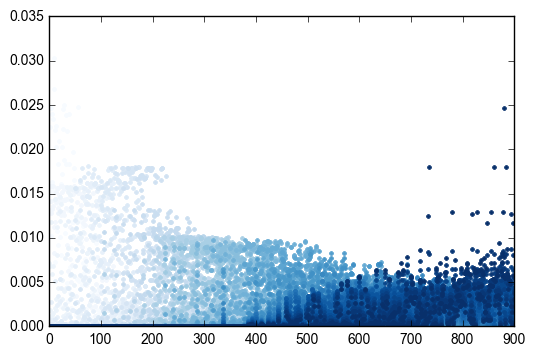

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = plt.cm.Blues(np.linspace(0, 1, K))
for k in range(K):
    plt.plot(W_nl[:,k],'.',color=colors[k])

The weight matrix makes sense. Later series (larger K) favor higher n (later in the protocol)

In [9]:
# This is for conversion to 2 indicies: state and snapshot
cum_N_state = np.cumsum([0] + list(N_k))

def linear_index_to_snapshot_index(ind):
  state_index = list(ind<cum_N_state).index(True)-1
  nis_index = ind-cum_N_state[state_index]
  return (state_index,nis_index)

# Selects new replica exchange snapshots
self.confs[process]['replicas'] = []
for k in range(K):
  (s,n) = linear_index_to_snapshot_index(\
    np.random.choice(range(W_nl.shape[0]), size = 1, p = W_nl[:,k])[0])
  self.confs[process]['replicas'].append(confs_repX[s][n])